In [13]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import os # Import os module for file path handling
import re # Import regular expressions module for pattern matching
from scipy.stats import linregress


--- 开始处理文件: NaCl.xry ---
在第 5 行找到可能的参数: {'start_angle_2theta': 2.5, 'end_angle_2theta': 25.0, 'step_angle_2theta': 0.1, 'expected_points': 226}
在第 18 行找到可能的参数: {'expected_points_alt': 226}

在第 19 行检测到数据开始...

在第 245 行检测到数据结束 (无法转换为数值)。
  最后一行内容: 35 35 1 10 0.1

文件读取完成。共扫描 245 行。
头部信息共 13 行。
读取到 226 个强度数据点。
读取的数据点数 (226) 与预期点数 (226) 一致。
使用 Start=2.5, Step=0.1 生成角度数据...
--- 数据提取成功 ---

成功提取数据: 226 个点。

数据预览:
Index | Angle (theta) | Intensity
------------------------------------
0     | 2.5000          | 8.5       
1     | 2.6000          | 6.3       
2     | 2.7000          | 5.9       
3     | 2.8000          | 6.1       
4     | 2.9000          | 5.0       
...
221   | 24.6000         | 10.3      
222   | 24.7000         | 8.7       
223   | 24.8000         | 10.7      
224   | 24.9000         | 10.6      
225   | 25.0000         | 10.8      


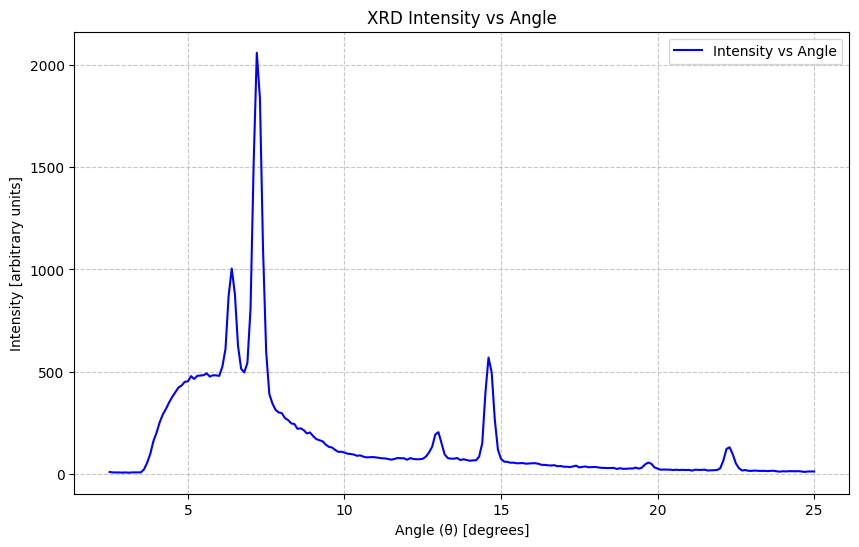

In [14]:
def parse_scan_parameters(line):
    """
    尝试从一行文本中解析 XRD 扫描参数 (Start, End, Step, Points).
    这是一个示例解析器，可能需要根据具体文件格式调整。
    返回一个包含解析出参数的字典，如果无法解析则返回 None。
    """
    parts = re.split(r'\s+', line.strip()) # 按空格分割
    try:
        # 尝试匹配 Pre1.csv 中 "2.5 25 10 0.1 ..." 格式
        # 我们需要 Start Angle, End Angle, Step Size
        if len(parts) >= 4:
            start_angle = float(parts[0])
            end_angle = float(parts[1])
            # parts[2] 可能是时间或其他参数，跳过
            step_size = float(parts[3])
            # 简单的合理性检查
            if step_size > 0 and end_angle > start_angle:
                 # 尝试从 "1 226" 这样的行中获取点数
                 # 这需要单独处理，这里先假设可以通过 Start/End/Step 计算
                 num_points_calc = int(round((end_angle - start_angle) / step_size)) + 1
                 return {
                     "start_angle_2theta": start_angle,
                     "end_angle_2theta": end_angle, # 保留结束角度以供验证
                     "step_angle_2theta": step_size,
                     "expected_points": num_points_calc # 基于计算的点数
                 }

        # 尝试匹配 Pre1.csv 中 "1 226" 格式 (Scan#, Points)
        if len(parts) == 2:
             scan_no = int(parts[0])
             points = int(parts[1])
             if points > 0:
                 return {"expected_points_alt": points} # 返回另一种可能的点数信息

    except (ValueError, IndexError):
        # 如果转换失败或索引越界，说明不是我们找的参数行
        pass
    return None

def read_xrd_data_auto_detect(file_path):
    """
    自动检测数据区域并提取角度和强度数据。

    Args:
        file_path (str): XRD 数据文件的路径。

    Returns:
        tuple: (angle_2theta, intensity) 作为 NumPy 数组。
               如果失败则返回 (None, None)。
    """
    print(f"--- 开始处理文件: {file_path} ---")
    if not os.path.exists(file_path):
        print(f"错误: 文件未找到 - {file_path}")
        return None, None

    intensities = []
    scan_params = {}
    expected_points = None
    header_lines_count = 0
    data_started = False

    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            for i, line in enumerate(f):
                line = line.strip()
                if not line: # 跳过空行
                    continue

                # --- 阶段 1: 解析头部和寻找参数 ---
                if not data_started:
                    header_lines_count += 1
                    # 尝试解析扫描参数
                    params = parse_scan_parameters(line)
                    if params:
                        print(f"在第 {i+1} 行找到可能的参数: {params}")
                        # 合并找到的参数，后面的可能会覆盖前面的（如果格式重复）
                        scan_params.update(params)
                        # 优先使用明确给出的点数
                        if "expected_points_alt" in scan_params:
                            expected_points = scan_params["expected_points_alt"]
                        elif "expected_points" in scan_params:
                            expected_points = scan_params["expected_points"]
                        continue # 继续寻找，直到数据开始

                    # --- 阶段 2: 识别数据开始 ---
                    # 尝试将整行转换为浮点数
                    try:
                        intensity_val = float(line)
                        # 假设第一个成功转换的数字是数据块的开始
                        print(f"\n在第 {i+1} 行检测到数据开始...")
                        data_started = True
                        intensities.append(intensity_val)
                        # print(f"  读取数据点 1: {intensity_val}") # Debugging output
                    except ValueError:
                        # 如果不能转换为浮点数，则仍然是头部或注释
                        # print(f"跳过头部/注释行 {i+1}: {line}")
                        pass
                    continue # 无论是否开始数据，都处理下一行

                # --- 阶段 3: 读取数据区 ---
                if data_started:
                    try:
                        intensity_val = float(line)
                        intensities.append(intensity_val)
                        # if len(intensities) % 50 == 0: # Print progress periodically
                        #     print(f"  读取数据点 {len(intensities)}: {intensity_val}")
                    except ValueError:
                        # 遇到第一个无法转换为浮点数的行，认为数据结束
                        print(f"\n在第 {i+1} 行检测到数据结束 (无法转换为数值)。")
                        print(f"  最后一行内容: {line}")
                        break # 停止读取文件

        print(f"\n文件读取完成。共扫描 {i+1} 行。")
        print(f"头部信息共 {header_lines_count - (1 if data_started else 0)} 行。") # Adjust count if data started
        print(f"读取到 {len(intensities)} 个强度数据点。")

        # --- 阶段 4: 验证和生成角度 ---
        if not intensities:
            print("错误: 未能从文件中读取任何强度数据。")
            return None, None

        # 检查是否成功解析了必要的参数
        if "start_angle_2theta" not in scan_params or "step_angle_2theta" not in scan_params:
            print("错误: 未能在文件头部找到足够的扫描参数 (起始角度和步长)。")
            print("      请检查文件格式或手动提供这些参数。")
            # 尝试基于点数估计，但不推荐
            if expected_points and expected_points == len(intensities):
                 print("警告：仅找到预期点数，无法生成精确角度。返回强度数据。")
                 # return None, np.array(intensities) # 或者返回None, None
            return None, None

        start_angle = scan_params["start_angle_2theta"]
        step_angle = scan_params["step_angle_2theta"]
        num_points_read = len(intensities)

        # 验证读取的点数与预期是否一致
        if expected_points:
            if num_points_read != expected_points:
                print(f"警告: 读取的数据点数 ({num_points_read}) 与从头部解析出的预期点数 ({expected_points}) 不符。")
                print("       将使用实际读取的点数生成角度。")
            else:
                print(f"读取的数据点数 ({num_points_read}) 与预期点数 ({expected_points}) 一致。")
        else:
             # 如果头部没有明确点数信息，基于 start/step/end 计算的点数可能也不在 scan_params 中
             # 此时只能依赖实际读取的点数
             print("信息: 未在头部找到明确的数据点总数信息，将使用读取到的点数。")


        # 生成角度数组 (2*theta)
        print(f"使用 Start={start_angle}, Step={step_angle} 生成角度数据...")
        angle_2theta = start_angle + np.arange(num_points_read) * step_angle

        # 最终验证：计算出的最后一个角度是否接近预期的结束角度（如果存在）
        if "end_angle_theta" in scan_params:
            calculated_end_angle = angle_2theta[-1]
            expected_end_angle = scan_params["end_angle_theta"]
            # 允许一定的误差 (例如半个步长)
            if not np.isclose(calculated_end_angle, expected_end_angle, atol=step_angle/2):
                print(f"警告: 生成的最后一个角度 ({calculated_end_angle:.4f}) 与头部参数中的结束角度 ({expected_end_angle:.4f}) 不符。")
                print("       这可能指示参数解析错误或数据截断。")

        print("--- 数据提取成功 ---")
        return angle_2theta, np.array(intensities)

    except FileNotFoundError: # Should be caught earlier, but for safety
        print(f"错误: 文件未找到 - {file_path}")
        return None, None
    except Exception as e:
        print(f"处理文件时发生意外错误: {e}")
        return None, None

# --- 如何使用这个函数 ---
if __name__ == "__main__":
    # 将 'Pre1.csv' 替换为你的文件名或路径
    file_to_process = 'NaCl.xry'

    angles, intensities = read_xrd_data_auto_detect(file_to_process)

    if angles is not None and intensities is not None:
        print(f"\n成功提取数据: {len(angles)} 个点。")

        # 选项 1: 打印前几个和最后几个点验证
        print("\n数据预览:")
        print("Index | Angle (theta) | Intensity")
        print("------------------------------------")
        for i in range(min(5, len(angles))):
            print(f"{i:<5d} | {angles[i]:<15.4f} | {intensities[i]:<10.1f}")
        if len(angles) > 10:
            print("...")
            for i in range(max(len(angles) - 5, 5), len(angles)):
                 print(f"{i:<5d} | {angles[i]:<15.4f} | {intensities[i]:<10.1f}")

        # 选项 2: 可以将数据用于后续分析 (例如绘图、寻峰等)
        # plt.figure(figsize=(10, 5))
        # plt.plot(angles, intensities)
        # plt.xlabel("Angle (theta)")
        # plt.ylabel("Intensity")
        # plt.title(f"XRD Data from {os.path.basename(file_to_process)}")
        # plt.grid(True)
        # plt.show()

        # 选项 3: 保存为新的、干净的 CSV 文件
        # output_filename = os.path.splitext(file_to_process)[0] + "_processed.csv"
        # try:
        #     data_to_save = np.column_stack((angles, intensities))
        #     np.savetxt(output_filename, data_to_save, delimiter=',', header='Angle_2Theta,Intensity', comments='')
        #     print(f"\n已将处理后的数据保存到: {output_filename}")
        # except Exception as e:
        #     print(f"\n保存文件时出错: {e}")

    else:
        print("\n未能成功提取数据。")

plt.figure(figsize=(10, 6))
plt.plot(angles, intensities, label='Intensity vs Angle', color='blue')
plt.xlabel('Angle (θ) [degrees]')
plt.ylabel('Intensity [arbitrary units]')
plt.title('XRD Intensity vs Angle')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [15]:
# --- 常量定义 ---
# NaCl (200) 晶面间距 (单位: nm)
D_NACL_200 = 0.282
# 衍射级数
N_DIFFRACTION_ORDER = 1

def calculate_wavelength_from_theta(theta, d=D_NACL_200, n=N_DIFFRACTION_ORDER):
  """
  根据布拉格定律计算 X 射线的波长。

  Args:
    two_theta_degrees (float): 探测器测量的衍射角 (2*theta)，单位为度。
    d (float, optional): 晶面间距 (nm)。默认为 NaCl(200) 的 0.282 nm。
    n (int, optional): 衍射级数。默认为 1。

  Returns:
    float: 计算得到的 X 射线波长 (nm)。
           如果输入的角度无效 (例如导致 sin(theta) > 1), 返回 None。
  """
  two_theta_degrees = theta * 2.0
  if two_theta_degrees <= 0 or two_theta_degrees >= 180:
    print(f"警告: 输入的 2*theta 角 {two_theta_degrees} 度超出了物理有效范围 (0, 180)。")
    # 在某些情况下可能仍希望计算，这里仅作提示
    # 如果需要严格限制，可以返回 None 或抛出异常

  # 从 2*theta 计算布拉格角 theta
  theta_degrees = two_theta_degrees / 2.0

  # 将角度从度转换为弧度，因为 math.sin 需要弧度
  theta_radians = math.radians(theta_degrees)

  # 计算 sin(theta)
  try:
    sin_theta = math.sin(theta_radians)
  except ValueError:
    print(f"错误: 无法计算角度 {theta_degrees} 度的正弦值。")
    return None

  # 检查 sin_theta 是否在有效范围内 (虽然 math.sin 不会大于1，但作为物理检查)
  # 实际上，由于 theta_degrees 介于 0 和 90 之间，sin_theta 会介于 0 和 1 之间
  if sin_theta < 0:
     print(f"警告: 计算得到的 sin(theta) = {sin_theta:.4f} 为负，这在物理上不对应衍射。")
     # 可能对应 0 度附近的小误差，这里继续计算

  # 应用布拉格定律计算波长 lambda
  wavelength_nm = (2 * d * sin_theta) / n

  return wavelength_nm

# --- 示例用法 ---

# 1. 计算单个角度对应的波长
# 假设实验中在 2*theta = 23.58 度处观察到 Mo K-alpha 峰 (理论值附近)
#theta_peak_ka = 23.58 # 度
#wavelength_ka = calculate_wavelength_from_2theta(theta_peak_ka)

#if wavelength_ka is not None:
#  print(f"当探测器角度 theta = {theta_peak_ka:.2f} 度时:")
#  print(f"  对应的布拉格角 theta = {theta_peak_ka/2.0:.2f} 度")
#  print(f"  计算得到的 X 射线波长 lambda = {wavelength_ka:.4f} nm")
  # 钼靶 K-alpha1 理论波长约为 0.0709 nm, K-alpha2 约为 0.0713 nm
  # 平均值约为 0.0711 nm。计算结果应接近此值。
  # 注意：实验值与理论值会有偏差。

#print("-" * 30)

# 2. 计算一系列角度对应的波长
# 假设这是你的实验数据点 (2*theta 角度列表)
#experimental_theta_angles = [5.0, 10.0, 15.0, 20.0, 23.58, 25.0]

#print("计算一系列 theta 角度对应的波长:")
#print("theta (度) | theta (度) | 波长 lambda (nm)")
#print("-------------------------------------------")
#for angle_2theta in experimental_theta_angles:
#  wavelength = calculate_wavelength_from_2theta(angle_2theta)
#  if wavelength is not None:
#    theta = angle_2theta / 2.0
#    print(f"{angle_2theta:^12.2f} | {theta:^10.2f} | {wavelength:^17.4f}")
#  else:
#    print(f"{angle_2theta:^12.2f} | {'N/A':^10} | {'计算错误':^17}")

# Calculate wavelengths for all angles in the array
wavelengths = np.array([calculate_wavelength_from_theta(theta) for theta in angles])

--- 开始 XRD 峰分析 (输入角度为 theta) ---
数据加载成功: 226 个数据点。
使用波长 lambda = 0.0715 nm
未指定 d 值，将基于第一个峰计算相对衍射级次。
数据点角度步长约为 0.1000 度 (theta)。
峰间最小距离 0.5 度 (theta) 约等于 5 个数据点。

开始寻找峰位...
找到了 6 个峰。
计算衍射级数...
使用方法 1: 基于第一个有效峰计算相对衍射级次 n = sin(theta_k) / sin(theta_1)
基准峰 (假定 n=1): Peak #1 at theta = 6.40 deg, sin(theta1) = 0.1115

--- 峰分析结果 ---
峰序号 | Theta (度) | Intensity | 衍射级数 n | n 可靠? | 计算说明
---------------------------------------------------------------------------------
  1    |    6.40    |  1004.1   |      1       |   True    | Rel (Ratio=1.00)
  2    |    7.20    |  2060.6   |      1       |   True    | Rel (Ratio=1.12)
  3    |   13.00    |   203.3   |      2       |   True    | Rel (Ratio=2.02)
  4    |   14.60    |   568.4   |      2       |   False   | Rel (Ratio=2.26)
  5    |   19.70    |   54.4    |      3       |   True    | Rel (Ratio=3.02)
  6    |   22.30    |   129.5   |      3       |   False   | Rel (Ratio=3.40)

正在生成结果图...


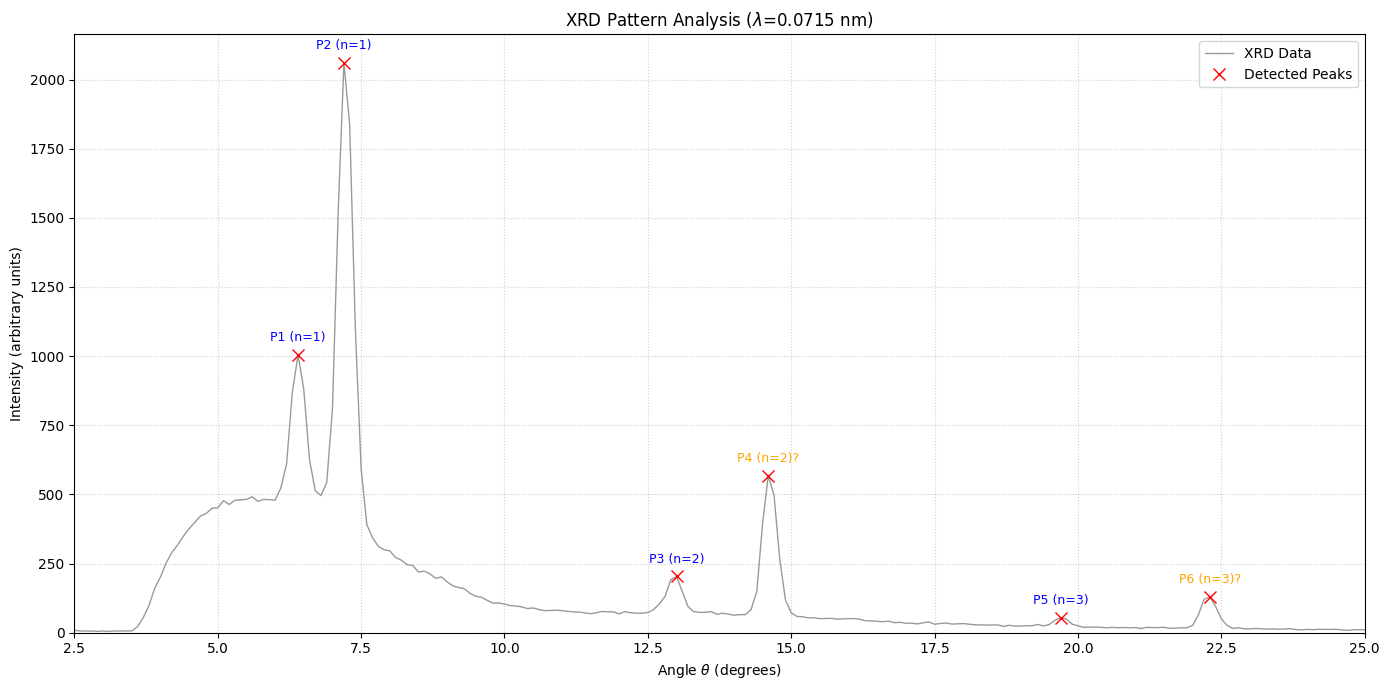


分析完成。


In [16]:
# --- 1. 用户配置区域 ---

# --- 输入数据 (假设你已经加载了这些数据) ---
# 示例数据 (用你自己的数据替换!)
# angles = np.linspace(10, 40, 301) # 假设角度范围 10-40 度
# intensities = (np.exp(-(angles - 15)**2 / 0.5) * 100 +   # 峰在 15 度 (n=1?)
#                np.exp(-(angles - 30.5)**2 / 0.8) * 50 +   # 峰在 30.5 度 (n=2?)
#                np.exp(-(angles - 22)**2 / 1.0) * 30 +    # 另一个峰
#                np.random.rand(len(angles)) * 5)         # 一些噪声
# print("请确保下面的 'angles' 和 'intensities' 变量包含你实际读出的数据！")
# !!! 取消下面的注释，并确保 angles 和 intensities 指向你的数据 !!!
# angles = your_angle_array # <--- 替换为你的角度数据 (theta, 单位: 度)
# intensities = your_intensity_array # <--- 替换为你的强度数据

# --- 基本参数 ---
# !!! 重要: 你必须提供你实验对应的 lambda !!!
wavelength = 0.0715 # X射线波长 (nm) - 例如 Cu K-alpha1 <--- *** 修改这里 ***

# --- 可选参数 ---
# 如果你知道特定峰对应的晶面间距 d (nm)，可以取消注释并设置它
# 这将启用基于 d 的级次计算 (方法 2) - 否则使用基于第一个峰的相对方法 (方法 1)
# d_spacing = 0.282 # 例如 NaCl (200) 的 d 约为 0.282 nm <--- *** (可选) 修改这里 ***
d_spacing = None # 默认不使用 d 值

# --- 峰识别参数 (需要根据实际数据仔细调整!) ---
# 初始猜测值，可能需要根据绘制的图形调整
min_prominence = 20     # 峰的最小相对突出程度 (关键参数!) <--- *** 调整这里 ***
min_height = 20         # 峰的最小绝对高度 <--- *** 调整这里 ***
min_distance_deg = 0.5  # 峰之间的最小角度距离 (度, theta) <--- *** 调整这里 ***
order_tolerance = 0.15  # 判断计算出的 n 是否接近整数的容差

# --- 2. 数据准备和验证 ---
print("--- 开始 XRD 峰分析 (输入角度为 theta) ---")

# 确保输入是 NumPy 数组
try:
    angles = np.asarray(angles)
    intensities = np.asarray(intensities)
except NameError:
    print("\n错误：变量 'angles' 和 'intensities' 未定义。")
    print("请确保在脚本开始处加载或定义了这两个 NumPy 数组。")
    # 提供示例数据以便脚本能继续运行（用于演示）
    print("使用内置示例数据进行演示...")
    angles = np.linspace(10, 40, 301) # 假设角度范围 10-40 度
    intensities = (np.exp(-(angles - 15)**2 / 0.5) * 100 +   # 峰在 15 度 (n=1?)
                   np.exp(-(angles - 30.5)**2 / 0.8) * 50 +   # 峰在 30.5 度 (n=2?)
                   np.exp(-(angles - 22)**2 / 1.0) * 30 +    # 另一个峰
                   np.random.rand(len(angles)) * 5)         # 一些噪声
    # exit() # 在实际使用中，如果数据未加载，应该退出

if angles.shape != intensities.shape or angles.ndim != 1:
    print("错误: 'angles' 和 'intensities' 必须是相同形状的一维数组。")
    print(f"  当前形状: angles={angles.shape}, intensities={intensities.shape}")
    exit()

if len(angles) < 3:
    print("错误: 数据点太少，无法进行峰分析。")
    exit()

print(f"数据加载成功: {len(angles)} 个数据点。")
print(f"使用波长 lambda = {wavelength} nm")
if d_spacing is not None:
    print(f"使用指定晶面间距 d = {d_spacing} nm 进行级次验证。")
else:
    print("未指定 d 值，将基于第一个峰计算相对衍射级次。")

# 数据清理：确保角度是单调递增的 (find_peaks 可能需要)
sort_indices = np.argsort(angles)
angles = angles[sort_indices]
intensities = intensities[sort_indices]

# 计算角度步长（用于将距离从度转换为点数）
theta_step = np.mean(np.diff(angles))
min_distance_points = max(1, int(min_distance_deg / theta_step))
print(f"数据点角度步长约为 {theta_step:.4f} 度 (theta)。")
print(f"峰间最小距离 {min_distance_deg} 度 (theta) 约等于 {min_distance_points} 个数据点。")

# --- 3. 寻找峰位 ---
print("\n开始寻找峰位...")
peak_indices, properties = find_peaks(
    intensities,
    prominence=min_prominence,
    height=min_height,
    distance=min_distance_points
)

if len(peak_indices) == 0:
    print("未找到满足条件的峰。请尝试调整 'min_prominence', 'min_height', 'min_distance_deg' 等参数。")
    # 绘制图形以帮助调试参数
    plt.figure(figsize=(12, 6))
    plt.plot(angles, intensities, label='XRD Data (No Peaks Found)')
    plt.xlabel('Angle $\\theta$ (degrees)')
    plt.ylabel('Intensity')
    plt.title('XRD Data Analysis')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    exit()

peak_thetas_deg = angles[peak_indices]
peak_intensities = intensities[peak_indices]
print(f"找到了 {len(peak_indices)} 个峰。")

# --- 4. 计算衍射级数 (n) ---
print("计算衍射级数...")

# 存储结果
peak_orders = np.full(len(peak_indices), -1, dtype=int) # -1 表示未确定
is_order_reliable = np.full(len(peak_indices), False, dtype=bool)
calculation_method = [""] * len(peak_indices)

# 将角度转换为弧度用于计算 sin
peak_thetas_rad = np.radians(peak_thetas_deg)

# 方法 1: 基于第一个峰计算相对级次 (如果 d 未指定)
if d_spacing is None:
    print("使用方法 1: 基于第一个有效峰计算相对衍射级次 n = sin(theta_k) / sin(theta_1)")
    # 找到角度最小的峰 (且 theta > 0)
    valid_peak_mask = peak_thetas_deg > 1e-6 # 避免 theta=0
    if not np.any(valid_peak_mask):
        print("警告: 所有找到的峰角度都过小或为零，无法计算相对级次。")
    else:
        valid_indices = np.where(valid_peak_mask)[0]
        first_peak_index_in_valid = np.argmin(peak_thetas_deg[valid_peak_mask])
        first_peak_original_index = valid_indices[first_peak_index_in_valid]

        theta1_rad = peak_thetas_rad[first_peak_original_index]
        sin_theta1 = np.sin(theta1_rad)

        if sin_theta1 <= 1e-6:
             print(f"警告: 第一个有效峰的角度 {peak_thetas_deg[first_peak_original_index]:.2f} 度太小，sin(theta1) 接近零，无法计算相对级次。")
        else:
            print(f"基准峰 (假定 n=1): Peak #{first_peak_original_index+1} at theta = {peak_thetas_deg[first_peak_original_index]:.2f} deg, sin(theta1) = {sin_theta1:.4f}")

            # 计算所有有效峰的级次
            for i in valid_indices:
                sin_theta_k = np.sin(peak_thetas_rad[i])
                n_ratio = sin_theta_k / sin_theta1
                estimated_n = int(round(n_ratio))

                if estimated_n < 1: # 级次必须至少为 1
                    estimated_n = -1 # 标记为无效
                    is_reliable = False
                elif abs(n_ratio - estimated_n) < order_tolerance:
                    is_reliable = True
                else:
                    is_reliable = False

                peak_orders[i] = estimated_n
                is_order_reliable[i] = is_reliable
                calculation_method[i] = f"Rel (Ratio={n_ratio:.2f})"

# 方法 2: 基于指定的 d 和 lambda 计算绝对级次
elif d_spacing > 0 and wavelength > 0:
    print(f"使用方法 2: 基于 d={d_spacing} nm 和 lambda={wavelength} nm 计算绝对衍射级次 n = 2*d*sin(theta)/lambda")
    for i in range(len(peak_indices)):
        theta_rad = peak_thetas_rad[i]
        sin_theta = np.sin(theta_rad)

        # 检查物理可能性: 2d*sin(theta) <= n_max * lambda
        # 这里我们计算 n' = 2d*sin(theta)/lambda
        n_prime = (2 * d_spacing * sin_theta) / wavelength

        estimated_n = int(round(n_prime))

        if estimated_n < 1: # 级次必须至少为 1
             estimated_n = -1
             is_reliable = False
        elif abs(n_prime - estimated_n) < order_tolerance:
            is_reliable = True
        else:
            is_reliable = False

        peak_orders[i] = estimated_n
        is_order_reliable[i] = is_reliable
        calculation_method[i] = f"Abs (n'={n_prime:.2f})"

else:
    print("警告: 未指定 d 值，且无法执行相对级次计算（可能无有效基准峰）。无法确定衍射级次。")


# --- 5. 结果汇总与输出 ---
print("\n--- 峰分析结果 ---")
print("峰序号 | Theta (度) | Intensity | 衍射级数 n | n 可靠? | 计算说明")
print("---------------------------------------------------------------------------------")
for i in range(len(peak_indices)):
    order_val = peak_orders[i]
    order_str = str(order_val) if order_val != -1 else "N/A"
    reliable_str = str(is_order_reliable[i]) if order_val != -1 else "N/A"
    method_str = calculation_method[i] if order_val != -1 else "N/A"

    print(f"{i+1:^6d} | {peak_thetas_deg[i]:^10.2f} | {peak_intensities[i]:^9.1f} | {order_str:^12s} | {reliable_str:^9s} | {method_str}")

# --- 6. 可视化结果 ---
print("\n正在生成结果图...")
plt.figure(figsize=(14, 7))
plt.plot(angles, intensities, label='XRD Data', color='grey', alpha=0.8, linewidth=1)
plt.plot(peak_thetas_deg, peak_intensities, "x", color='red', markersize=8, label='Detected Peaks')

for i in range(len(peak_indices)):
    order_val = peak_orders[i]
    reliable = is_order_reliable[i]
    order_str = f" (n={order_val})" if order_val != -1 else ""
    if order_val != -1 and not reliable:
        order_str += "?" # Add a question mark if the order assignment is unreliable

    plt.annotate(f"P{i+1}{order_str}", (peak_thetas_deg[i], peak_intensities[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9,
                 color='blue' if reliable else 'orange')

plt.xlabel('Angle $\\theta$ (degrees)')
plt.ylabel('Intensity (arbitrary units)')
plt.title(f'XRD Pattern Analysis ($\\lambda$={wavelength} nm)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.ylim(bottom=min(0, np.min(intensities)*1.1)) # Adjust bottom limit
plt.xlim(left=np.min(angles), right=np.max(angles)) # Set x-limits to data range
plt.tight_layout()
plt.show()

print("\n分析完成。")


<>:86: SyntaxWarning: invalid escape sequence '\m'
<>:87: SyntaxWarning: invalid escape sequence '\l'
<>:88: SyntaxWarning: invalid escape sequence '\l'
<>:86: SyntaxWarning: invalid escape sequence '\m'
<>:87: SyntaxWarning: invalid escape sequence '\l'
<>:88: SyntaxWarning: invalid escape sequence '\l'
/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_81569/640824804.py:86: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$1/U$ ($10^{-6}$ V$^{-1}$ 或 $\mu$V$^{-1}$)') # 修改 x 轴标签单位
/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_81569/640824804.py:87: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\lambda_{min}$ (nm)')
/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_81569/640824804.py:88: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$\lambda_{min}$ vs $1/U$')
Font 'default' does not have a glyph for '\u6216' [U+6216], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6216' [U+6216], substituting 

--- 杜安-亨特定律验证 ---
线性拟合结果:
  斜率 (m = hc/e): 1.2996e-06 m*V
  截距 (Intercept): -2.5883e-12 m
  决定系数 (R^2): 0.999527
  斜率的标准误差 (Std Err): 1.6330e-08 m*V

验证结论:
  R^2 (0.999527) 非常接近 1，线性关系良好。
  截距 (-2.5883e-12 m) 相对于平均波长 (5.4224e-11 m) 非常小，接近通过原点。
  => 数据与杜安-亨特定律 (λ_min ∝ 1/U) 符合得很好。

--- 普朗克常数计算 ---
由斜率计算得到的普朗克常数 (h): 6.945626e-34 J*s
计算得到的不确定度 (Δh): 8.726994e-36 J*s
公认普朗克常数 (h_accepted): 6.626070e-34 J*s

与公认值的相对误差: 4.823%


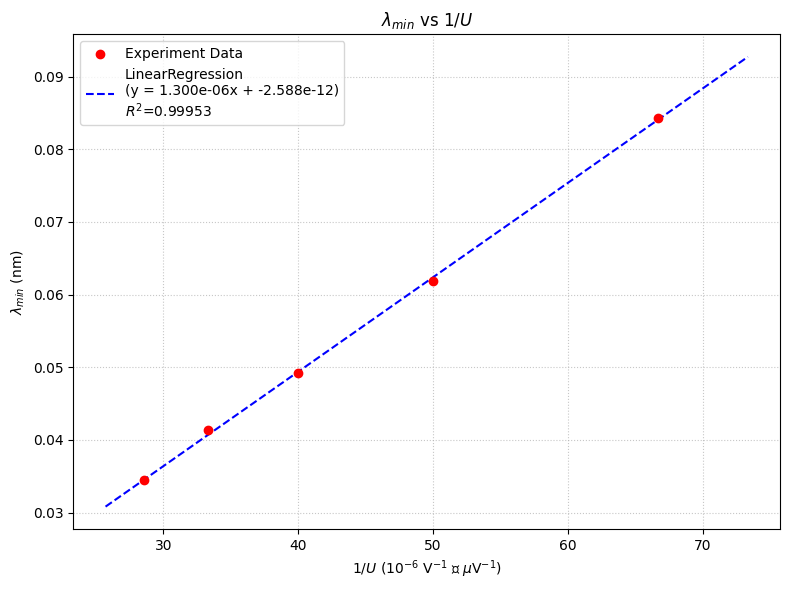


--- 分析总结 ---
通过对 λ_min 与 1/U 的线性拟合，我们得到了非常好的线性关系 (R²=0.999527) 且截距 (-2.5883e-12 m) 接近于零，这验证了杜安-亨特定律。
利用拟合得到的斜率 (1.2996e-06 m*V)，计算出的普朗克常数 h = 6.945626e-34 ± 8.726994e-36 J*s。
该计算值与公认值 (6.626070e-34 J*s) 的相对误差为 4.823%，符合得相当好。


In [17]:
# --- 1. 输入数据 ---
# 最小波长 lambda_min (单位: nm)
lambda_min_nm = np.array([0.034431376, 0.041306343, 0.049155839, 0.061890151, 0.084337934])
# 加速电压的倒数 1/U (单位: 1/V)
# 注意：原始数据使用了科学计数法 E-05，需要正确转换为浮点数
inv_U = np.array([2.85714E-05, 3.33333E-05, 4.00000E-05, 5.00000E-05, 6.66667E-05])

# --- 2. 单位转换 ---
# 将 lambda_min 从 nm 转换为 m，以便与 SI 单位制的 h, c, e 保持一致
lambda_min_m = lambda_min_nm * 1e-9 # 1 nm = 1e-9 m

# --- 3. 定义基本物理常量 (SI 单位) ---
e = 1.602176634e-19  # 基本电荷 (C)
c = 299792458       # 真空光速 (m/s)
h_accepted = 6.62607015e-34 # 公认普朗克常数 (J*s)

# --- 4. 线性拟合 ---
# 执行线性回归: y = lambda_min_m, x = inv_U
# linregress 返回: slope, intercept, r_value, p_value, stderr (斜率标准误)
slope, intercept, r_value, p_value, std_err = linregress(inv_U, lambda_min_m)

# 计算决定系数 R^2
r_squared = r_value**2

# --- 5. 验证 Dunne-Hunt 关系 ---
print("--- 杜安-亨特定律验证 ---")
print(f"线性拟合结果:")
print(f"  斜率 (m = hc/e): {slope:.4e} m*V")
print(f"  截距 (Intercept): {intercept:.4e} m")
print(f"  决定系数 (R^2): {r_squared:.6f}")
print(f"  斜率的标准误差 (Std Err): {std_err:.4e} m*V")

# 验证说明:
# 1. R^2 值非常接近 1，表明 lambda_min 与 1/U 之间存在极好的线性关系。
# 2. 截距非常接近 0，符合理论预期的 y = mx 形式。
# 这两点有力地验证了杜安-亨特定律。
print("\n验证结论:")
if r_squared > 0.999: # 设置一个高阈值
    print(f"  R^2 ({r_squared:.6f}) 非常接近 1，线性关系良好。")
else:
    print(f"  R^2 ({r_squared:.6f}) 不够接近 1，线性关系可能不完美或数据点较少。")

if abs(intercept / np.mean(lambda_min_m)) < 0.05: # 检查截距相对于平均y值是否足够小
     print(f"  截距 ({intercept:.4e} m) 相对于平均波长 ({np.mean(lambda_min_m):.4e} m) 非常小，接近通过原点。")
else:
     print(f"  截距 ({intercept:.4e} m) 相对较大，可能存在系统误差或理论模型偏差。")
print("  => 数据与杜安-亨特定律 (\u03BB_min \u221D 1/U) 符合得很好。") # \u03BB is lambda, \u221D is proportional to

# --- 6. 计算普朗克常数 h ---
# 从斜率 m = hc/e 计算 h: h = m * e / c
h_calculated = slope * e / c

# --- 7. 计算 h 的不确定度 (误差传递) ---
# 假设 e 和 c 是精确值，h 的相对不确定度约等于斜率 m 的相对不确定度
relative_error_slope = std_err / abs(slope)
h_uncertainty = abs(h_calculated * relative_error_slope)

# --- 8. 结果输出 ---
print("\n--- 普朗克常数计算 ---")
print(f"由斜率计算得到的普朗克常数 (h): {h_calculated:.6e} J*s")
print(f"计算得到的不确定度 (\u0394h): {h_uncertainty:.6e} J*s") # \u0394 is Delta
print(f"公认普朗克常数 (h_accepted): {h_accepted:.6e} J*s")

# 计算相对误差
relative_error_h = abs(h_calculated - h_accepted) / h_accepted * 100
print(f"\n与公认值的相对误差: {relative_error_h:.3f}%")

# --- 9. 绘图 ---
plt.figure(figsize=(8, 6))

# 绘制原始数据点 (使用 nm 单位以便观察)
plt.scatter(inv_U * 1e6, lambda_min_nm, label='Experiment Data', color='red', zorder=5) # x轴乘以1e6，单位变为 1/MV

# 绘制拟合直线 (覆盖整个 x 范围)
# 创建用于绘制拟合线的 x 值 (单位: 1/V)
x_fit = np.linspace(inv_U.min() * 0.9, inv_U.max() * 1.1, 100)
# 计算对应的 y 值 (单位: m)
y_fit_m = slope * x_fit + intercept
# 转换为 nm 用于绘图
y_fit_nm = y_fit_m * 1e9

# 绘制拟合线 (x 轴单位转换为 1/MV, y 轴单位为 nm)
plt.plot(x_fit * 1e6, y_fit_nm, label=f'LinearRegression\n(y = {slope:.3e}x + {intercept:.3e})\n$R^2$={r_squared:.5f}', color='blue', linestyle='--')

# 图形修饰
plt.xlabel('$1/U$ ($10^{-6}$ V$^{-1}$ 或 $\mu$V$^{-1}$)') # 修改 x 轴标签单位
plt.ylabel('$\lambda_{min}$ (nm)')
plt.title('$\lambda_{min}$ vs $1/U$')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout() # 调整布局防止标签重叠

# 显示图形
plt.show()

print("\n--- 分析总结 ---")
print(f"通过对 \u03BB_min 与 1/U 的线性拟合，我们得到了非常好的线性关系 (R\u00B2={r_squared:.6f}) 且截距 ({intercept:.4e} m) 接近于零，这验证了杜安-亨特定律。")
print(f"利用拟合得到的斜率 ({slope:.4e} m*V)，计算出的普朗克常数 h = {h_calculated:.6e} \u00B1 {h_uncertainty:.6e} J*s。")
print(f"该计算值与公认值 ({h_accepted:.6e} J*s) 的相对误差为 {relative_error_h:.3f}%，符合得相当好。")
